## Hardware Testbed and Large-scale Testbed Co-simulation

## Co-Simulation

In [1]:
# --- imports ---

import os

import time
import logging
logger = logging.getLogger(__name__)

import time, datetime
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

import matplotlib.pyplot as plt
import scienceplots

import andes
andes.config_logger(stream_level=50)
print(andes.__version__)

from core_io import data_read, data_write, io_config, cs_stat, cs_config, cs_col

1.8.7.post5+gb9281204


### Co-Simulation

In [2]:
# --- set case ---
read_file = 'datar.txt'
write_file = 'dataw.txt'

# --- set path ---
path_proj = os.getcwd()
path_case = os.path.join(path_proj, 'case')
path_data = os.path.join(path_proj, 'data')

read_path = os.path.join(path_data, read_file)
write_path = os.path.join(path_data, write_file)

path_out = os.path.join(os.path.abspath('..'), 'output')

case1 = os.path.join(path_case, 'ieee14_htb.xlsx')
case2 = os.path.join(path_case, 'pjm5_htb.xlsx')
case3 = os.path.join(path_case, 'npcc_htb.xlsx')
case4 = os.path.join(path_case, 'ieee39_htb.xlsx')

ss = andes.load(case4,
                no_output=True,
                default_config=False,
                setup=False)

offline = True

# --- AGC settings ---
intv_agc = 4  # interval of AGC

AGC_control = 1  # 1: AGC control, 0: no AGC control

tgov_idx = 'TGOV1_1'  # TurbineGov idx

# ACE vars for PI controller
ACE_integral = 0
ACE_raw = 0
Kp = 0.005  # 0.05
Ki = 0.001

#  --- HTB variables ---
pq_htb = 'PQ_2'  # load represents for HTB
bus_htb = ss.PQ.get(idx=pq_htb, src='bus', attr='v')  # get bus index of HTB
bus_slack = ss.Slack.bus.v[0]  # get bus index of slack bus

# add Bus Freq. Measurement to HTB bus
ss.add('BusFreq', {'idx': 'BusFreq_HTB',
                   'name': 'BusFreq_HTB',
                   'bus': bus_htb,
                   'Tf': 0.02,
                   'Tw': 0.02,
                   'fn': 60})
ss.add('BusFreq', {'idx': 'BusFreq_Slack',
                   'name': 'BusFreq_Slack',
                   'bus': bus_slack,
                   'Tf': 0.02,
                   'Tw': 0.02,
                   'fn': 60})

ss.add('Output', {'model': 'GENCLS',
                   'varname': 'omega'})
ss.add('Output', {'model': 'GENROU',
                   'varname': 'omega'})
ss.add('Output', {'model': 'Bus',
                   'varname': 'a'})
ss.add('Output', {'model': 'Bus',
                   'varname': 'v'})

ss.setup()

msg_ltb = f"LTB case: {ss.files.case.split('/')[-1]}.\n"
msg_htb = f"HTB is load {pq_htb} which connects to LTB bus {bus_htb} in LTB."
logger.warning(msg_ltb + msg_htb)

rows = np.ceil((cs_config['t_total'] - cs_config['ti'] + 1) / cs_config['t_step'])
cs_num = -1 * np.ones((int(rows), len(cs_col)))

const_freq = 2 * np.pi * ss.config.freq  # constant to calculate bus angle
flag_init = True  # Flag to indicate the very first iteration
flag_tc0 = True  # Flag to record `tc0`

flag_datar = False  # Flag to indicate if data read is successful
flag_dataw = False  # Flag to indicate if data write is successful

flag_base = True  # Flag t0 update counter base

# --- system initial conditions ---

a0 = ss.Bus.get(idx=bus_slack, src='a', attr='v')  # initial slack bus angle
p0 = ss.PQ.get(idx=pq_htb, src='p0', attr='v')  # initial HTB bus active power
q0 = ss.PQ.get(idx=pq_htb, src='q0', attr='v')  # initial HTB bus reactive power

ss.TDS.config.no_tqdm = 1  # turn off tqdm progress bar
ss.TDS.config.criteria = 0  # turn off stability criteria

# set constant power load
ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0
ss.PQ.pq2z = 0

ss.TDS.config.save_every = 0
ss.TDS.config.save_mode = 'manual'

ss.PFlow.run()  # solve power flow
ss.TDS.config.tf = cs_config['ti']
ss.TDS.run()

t0_htb = time.time()

rows = cs_config['t_total'] / cs_config['t_step']
k0 = 0

logger.warning("LTB ready, start HTB.")

while (cs_stat['kr'] != 11):
    # --- repeat reading data until kr==11 ---
    [cs_stat['kr'], cs_stat['p'], cs_stat['q']], txtc, flag_datar = data_read(file=read_path, config=io_config)
    if offline:
        cs_stat['kr'] = 11  # Force set kr to 11 for offline test
    kr0 = cs_stat['kr']
    k0 = cs_stat['k']
    # --- reset io_config default values ---
    [io_config['p_df'], io_config['q_df']] = [cs_stat['p'], cs_stat['q']]
flag_init = False  # Turn off init_flag after first iteration
logger.warning("Co-sim initialized.")
while cs_stat['k'] < rows:
    if flag_tc0:
        tc0 = time.time()  # record clock time
        flag_tc0 = False
    # --- data read ---
    # NOTE: repeat reading data until counter update
    iter_read = 0
    k0 = cs_stat['k']
    # NOTE: repeat reading data until read counter `cs_stat['kr]` update
    t0_htb = time.time()
    while (cs_stat['kr'] != kr0 + 1) & (iter_read <= cs_config['itermax_io']):
        [cs_stat['kr'], cs_stat['p'], cs_stat['q']], txtc, flag_datar = data_read(file=read_path, config=io_config)
        if offline:
            cs_stat['kr'] = kr0 + 1  # Force update kr for offline test
        [io_config['p_df'], io_config['q_df']] = [cs_stat['p'], cs_stat['q']]
        iter_read += 1
    if iter_read > cs_config['itermax_io']:
        cs_stat['p'], cs_stat['q'] = io_config['p_df'], io_config['q_df']
    tc1 = time.time()  # record clock time
    # NOTE: update cumulative counter if read counter update successfully
    kr0 = cs_stat['kr']
    k0 = cs_stat['k']
    cs_stat['k'] += 1
    # --- LTB sim ---
    # --- info ---
    if np.mod(cs_stat['k'], 200) == 0:
        logger.warning("LTB simulated to %ds" % ss.TDS.config.tf)
    # --- send data to HTB ---
    # NOTE: Make sure `BusFreq` is connected to the load bus
    f_bus = ss.BusFreq.get(idx='BusFreq_HTB', src='f', attr='v')  # p.u.
    v_bus = ss.Bus.get(idx=bus_htb, src='v', attr='v')  # RMS, p.u.
    dataw = [v_bus, f_bus]  # LTB: voltage, frequency
    data_write(dataw=dataw, file=write_path, config=io_config)
    tc2 = time.time()  # send end time
    # --- LTB simulation ---
    p_inj = cs_config['load_switch'] * cs_stat['p']
    q_inj = cs_config['load_switch'] * cs_stat['q']
    # a) set PQ data in LTB
    ss.PQ.set(value=p_inj + p0, idx=pq_htb, src='Ppf', attr='v')
    ss.PQ.set(value=q_inj + q0, idx=pq_htb, src='Qpf', attr='v')
    # b) TDS
    ss.TDS.config.tf += cs_config['t_step']
    # AGC
    if cs_stat['k'] * cs_config['t_step'] % intv_agc == 0:
        ss.TurbineGov.set(src='paux0', idx=tgov_idx, attr='v', value=AGC_control * ACE_raw)
    ss.TDS.run()
    tc3 = time.time()  # record clock time
    # NOTE: tf_htb is the end time of last round
    # update AGC PI Controller
    ACE_integral = ACE_integral + ss.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ss.ACEc.ace.v.sum() + Ki*ACE_integral)
    if tc3 - t0_htb > 2 * cs_config['t_step']:
        cs_stat['iter_fail'] += 1
    cs_stat['tf'] = ss.TDS.config.tf  # LTB end time
    cs_stat['tr'] = tc1 - t0_htb  # read time
    cs_stat['tw'] = tc2 - tc1  # write time
    cs_stat['tsim'] = tc3 - tc2  # write time
    cs_stat['freq'] = f_bus  # freq of HTB bus
    cs_stat['v'] = v_bus  # freq of HTB bus
    # update HTB time
#     t0_htb += cs_config['t_step']
    cs_stat['iter_total'] += 1
    flag_base = True
    #  --- record data ---
    for col in cs_col:
        cs_num[cs_stat['k']-1, cs_col.index(col)] = cs_stat[col]
    # update counter base
    if flag_base & (cs_stat['kr'] == 199):
        cs_stat['kr'] = 10
        kr0 = 10
        flag_base = False

logger.warning("Co-sim finished.")


LTB case: ieee39_htb.xlsx.
HTB is load PQ_2 which connects to LTB bus 4 in LTB.
LTB ready, start HTB.
Co-sim initialized.
LTB simulated to 10s
LTB simulated to 20s
Co-sim finished.


In [3]:
# --- save data ---
cosim_out = pd.DataFrame(data=cs_num[:cs_stat['iter_total']], columns=cs_col)
# Time to datetime
time_struct = time.localtime(tc0)
date_string = time.strftime('%Y%m%d_%H%M', time_struct)
outfile = f'output_{date_string}.csv'
csv_out = os.path.join(path_out, outfile)

cosim_out['tall'] = cosim_out['tw'] + cosim_out['tr']+ cosim_out['tsim']
cosim_out.to_csv(csv_out, index=False, header=True)
logger.warning(f"Co-sim data save as: {csv_out}")

# --- plot data ---
cosim_plt = cosim_out.copy()
cosim_plt[['p', 'q']] = cosim_plt[['p', 'q']] * ss.config.mva   # p.u. to nominal value
cosim_plt[['tw', 'tr', 'tsim', 'tall']] = cosim_plt[['tw', 'tr', 'tsim', 'tall']] * 1000  # s to ms
cosim_plt['freq'] = cosim_plt['freq'] * ss.config.freq  # p.u. to Hz

Co-sim data save as: /home/jwang175/hlcosim/output/output_20230408_0029.csv


In [4]:
%matplotlib inline

<Axes: xlabel='Time [s]', ylabel='Voltage [p.u.]'>

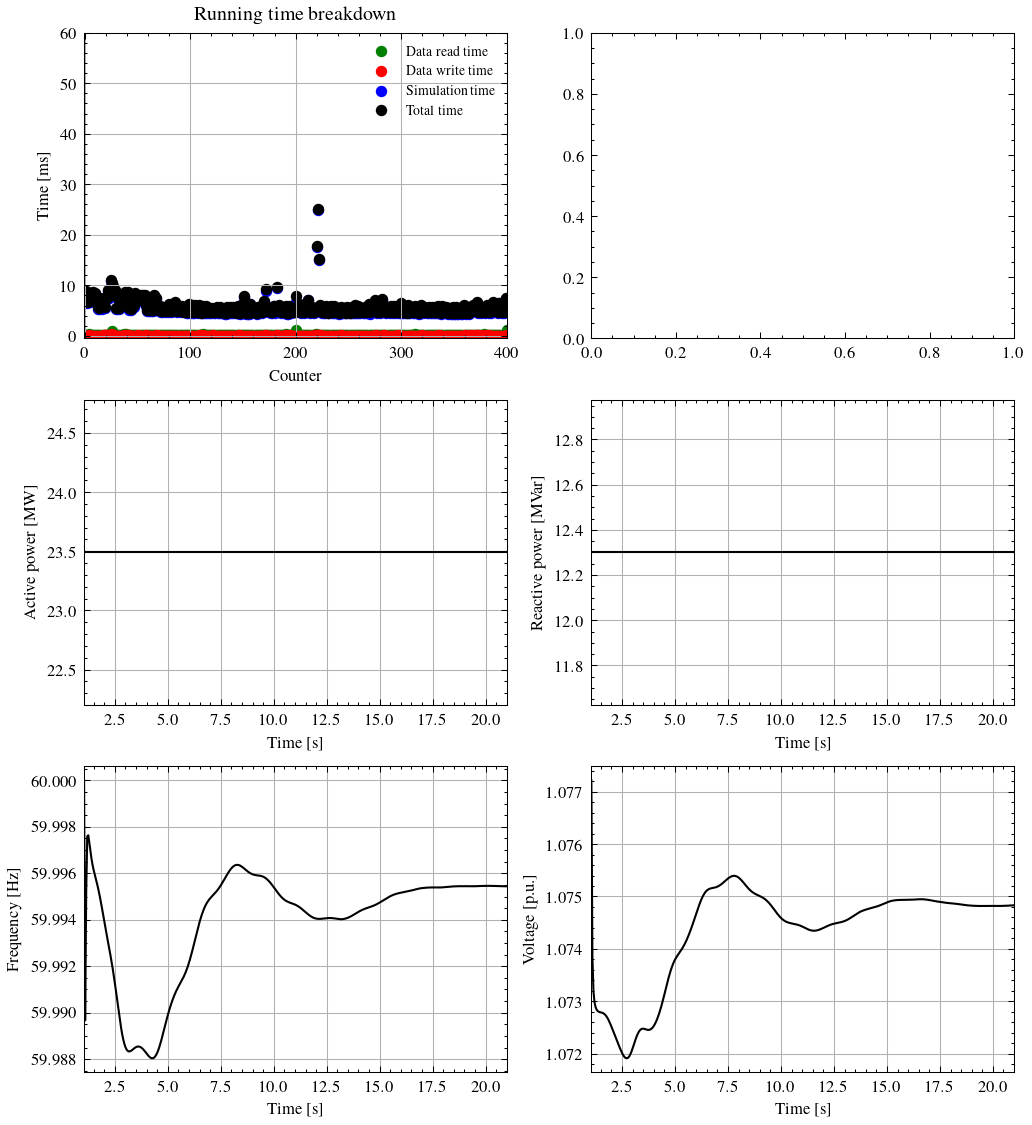

In [31]:
fig0, ax0 = plt.subplots(3, 2, figsize=(8, 9), dpi=150)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.style.use(['science', 'ieee'])

x, fig, ax = 'k', fig0, ax0[0, 0]
cosim_plt.plot.scatter(y='tw', color='green', label='Data read time', x=x, fig=fig, ax=ax)
cosim_plt.plot.scatter(y='tr', color='red', label='Data write time', x=x, fig=fig, ax=ax)
cosim_plt.plot.scatter(y='tsim', color='blue', label='Simulation time', x=x, fig=fig, ax=ax)
cosim_plt.plot.scatter(y='tall', color='black', label='Total time', x=x, fig=fig, ax=ax)

ax.legend(loc='upper right', fontsize='small')
ax.set_xlabel('Counter')
ax.set_ylabel('Time [ms]')
ax.grid(True)
ax.set_title('Running time breakdown')
ax.set_xlim([-0.5, cs_stat['iter_total']])
ax.set_ylim([-0.5, 1.2 * 50])

xlim = [cosim_plt['tf'].iloc[0], cosim_plt['tf'].iloc[-1]]
cosim_plt.plot(x='tf', y=['p'],
               fig=fig, ax=ax0[1, 0],
               xlabel='Time [s]', ylabel='Active power [MW]', grid=True,
               xlim=xlim, legend=False,
               )
cosim_plt.plot(x='tf', y=['q'],
               fig=fig, ax=ax0[1, 1],
               xlabel='Time [s]', ylabel='Reactive power [MVar]', grid=True,
               xlim=xlim, legend=False,
               )
cosim_plt.plot(x='tf', y=['freq'],
               fig=fig, ax=ax0[2, 0],
               xlabel='Time [s]', ylabel='Frequency [Hz]', grid=True,
               xlim=xlim, legend=False,
               )
cosim_plt.plot(x='tf', y=['v'],
               fig=fig, ax=ax0[2, 1],
               xlabel='Time [s]', ylabel='Voltage [p.u.]', grid=True,
               xlim=xlim, legend=False,
               )